In [1]:
from pathlib import Path
import json
import numpy as np
import torch
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from common import haversine_cluster, str_contains_sub, haversine_np, RADIUS_EARTH_KM, normalize_lat_long
from models import MlpTriangulationModel, mmles_np

In [2]:
model_dir = Path("models/20230213-164647")

In [3]:
df_clusters = pd.read_csv(model_dir / "clusters.csv")

In [4]:
with open(model_dir/"metadata.json", "r") as f:
    metadata = json.load(f)

lat_bounds = [metadata["zone"]["latitude"]["min"], metadata["zone"]["latitude"]["max"]]
long_bounds = [metadata["zone"]["longitude"]["min"], metadata["zone"]["longitude"]["max"]]

label_cols = metadata["model"]["output_features"]
sample_cols = metadata["model"]["input_features"]
X_TRAIN_MIN = np.asarray(metadata["model"]["input_normalization"]["input_features_min"])
X_TRAIN_RANGE = np.asarray(metadata["model"]["input_normalization"]["input_features_range"])

In [5]:
# Should be a csv containing processed samples, which are cleaned with pre-calculated naive trilat coords 
# (see process.ipynb)
df = pd.read_csv("data/processed_samples_for_inference.csv")
if "id" in df.columns:
    df = df.drop(["id"], axis=1)

In [6]:
before = len(df)
for prefix in {"target", "hotspot1", "hotspot2", "hotspot3"}:
    df = df[df[f"{prefix}_lat"] > min(lat_bounds)]
    df = df[df[f"{prefix}_lat"] < max(lat_bounds)]
    df = df[df[f"{prefix}_long"] > min(long_bounds)]
    df = df[df[f"{prefix}_long"] < max(long_bounds)]
after = len(df)
print(f"Removed {before - after} samples outside zone. {after} samples remaining")

Removed 3 samples outside zone. 422 samples remaining


In [7]:
# Add cluster assignments and their normalized values
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    # Assign a cluster_id
    df[f"{prefix}_cluster_id"] = haversine_cluster(
        points_lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy(),
        centroids_lat_long_deg=df_clusters[["cluster_lat", "cluster_long"]].to_numpy(),
        trace=True,
    )
    # normalize cluster_id
    df[f"{prefix}_cluster_id_norm"] = 2 * df[f"{prefix}_cluster_id"] / (len(df_clusters) - 1) - 1

100%|██████████| 3224/3224 [00:00<00:00, 37680.60it/s]


In [8]:
# Add normalized lat, long
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    df[[f"{prefix}_lat_norm", f"{prefix}_long_norm"]] = normalize_lat_long(
        lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy()
    )

In [9]:
y_samples_ll = df[["target_lat", "target_long"]].to_numpy()
y_samples_naive_ll = df[["naive_tri_lat", "naive_tri_long"]].to_numpy()
y_samples = df[label_cols].to_numpy().squeeze()
x_samples = df[sample_cols].to_numpy()

# Normalize all features to expected range -1:1 based on consideration of the training data alone
for i, s in enumerate(sample_cols):
    # Avoid re-normalizing anything that was already normalized
    if str_contains_sub(s, ["_norm"]):
        continue
    print(f"Normalizing: {s}...")
    x_samples[:, i] = 2 * (x_samples[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1

print(x_samples.shape)
print(x_samples.min(axis=0))
print(x_samples.max(axis=0))

Normalizing: hotspot1_rssi...
Normalizing: hotspot2_rssi...
Normalizing: hotspot3_rssi...
Normalizing: hotspot1_snr...
Normalizing: hotspot2_snr...
Normalizing: hotspot3_snr...
(422, 21)
[-0.6295377  -0.6295377  -0.61898852 -0.74371703 -0.72385976  0.41752761
 -0.68047632  0.41764142 -0.68052461  0.41668662 -0.68055131  0.4168787
 -0.68047576 -0.87596899 -0.86915888 -0.77777778 -0.64640886 -0.70868344
 -0.77011494  0.4175275  -0.68047639]
[ 0.71331058  0.71331058  0.75550729  0.78963698  0.80577102  0.42105354
 -0.67881658  0.42116596 -0.67891593  0.42123981 -0.67856313  0.42129404
 -0.67856313 -0.34883721 -0.23364486 -0.02222222  0.73480662  0.69187676
  0.66666666  0.42105279 -0.67881649]


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [11]:
Xsamples = torch.tensor(x_samples).float().to(device)

In [12]:
model = torch.load(model_dir/ "model.pth")
model.to(device)

MlpTriangulationModel(
  (classifier): DisMaxLossFirstPart(num_features=128, num_classes=3224)
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=21, out_features=128, bias=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=False)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=128, bias=False)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=False)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=128, bias=False)
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [13]:
model.eval()
with torch.no_grad():
    logits = model(Xsamples)
    softmax_scores = model.get_softmax_scores_for_logits(logits)

logits = logits.cpu().numpy()
softmax_scores = softmax_scores.cpu().numpy()
mmles_scores = mmles_np(logits)

In [14]:

predicted_cluster_idxs = softmax_scores.argmax(axis=1).squeeze()
confidence = softmax_scores.max(axis=1)

is_correct = predicted_cluster_idxs == y_samples.squeeze()
print(sum(is_correct)/is_correct.shape[0])

predicted_lat_long = df_clusters[["cluster_lat", "cluster_long"]].to_numpy()[predicted_cluster_idxs, :]

dist_err_km = haversine_np(
    predicted_lat_long, 
    y_samples_ll, 
    radius=RADIUS_EARTH_KM
)
naive_tri_dist_err_km = haversine_np(
    y_samples_naive_ll, 
    y_samples_ll, 
    radius=RADIUS_EARTH_KM
)

0.009478672985781991


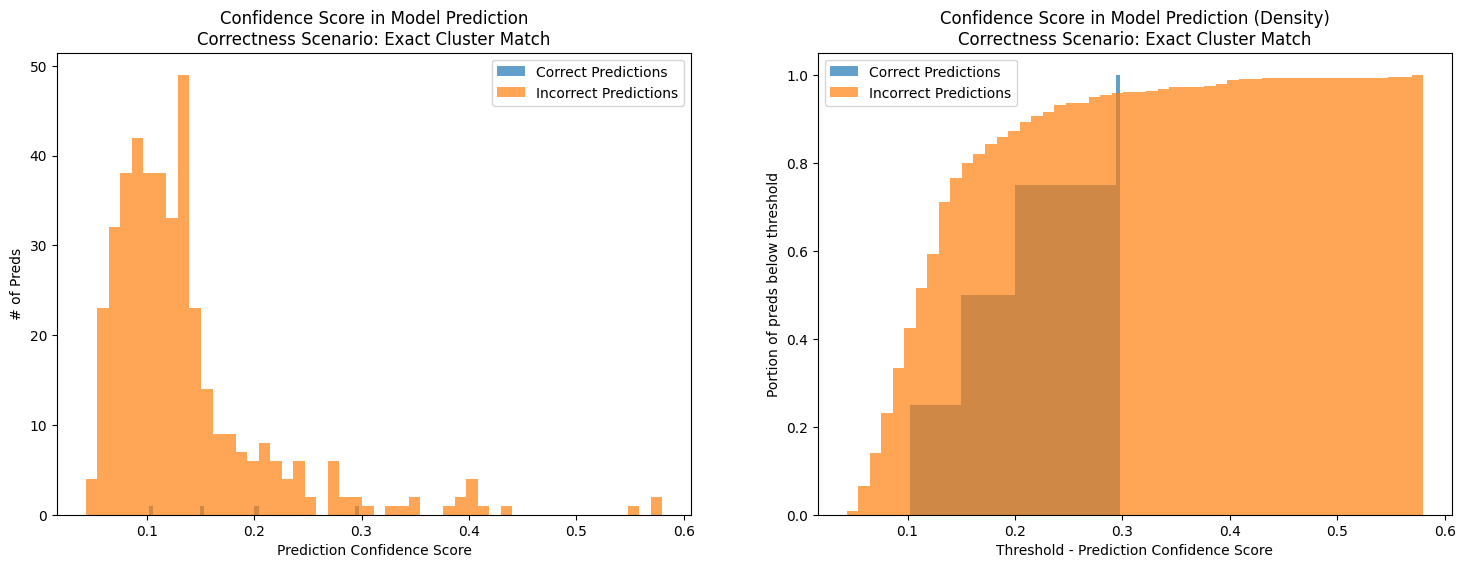

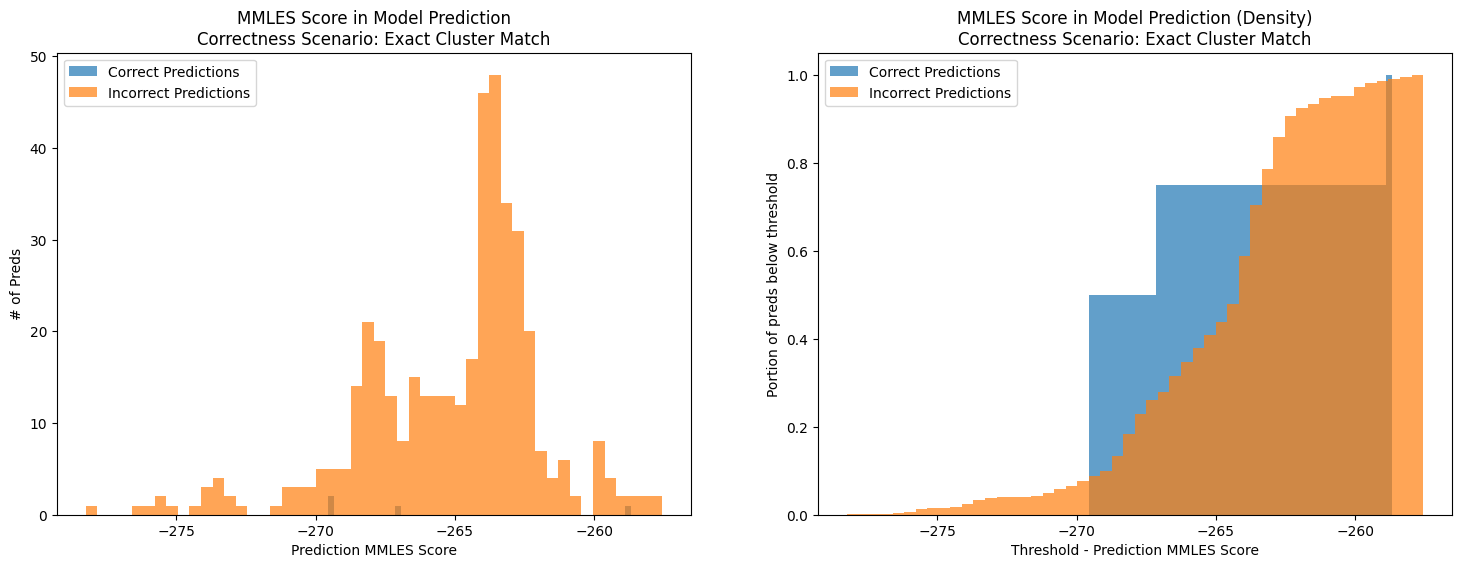

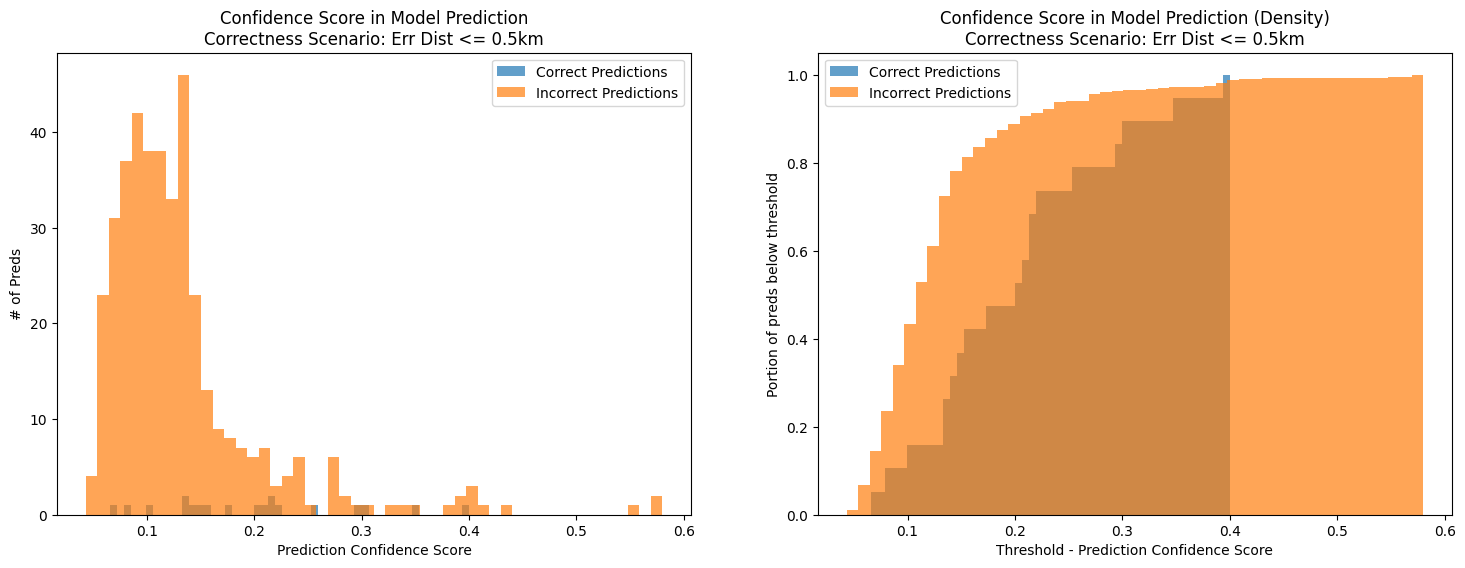

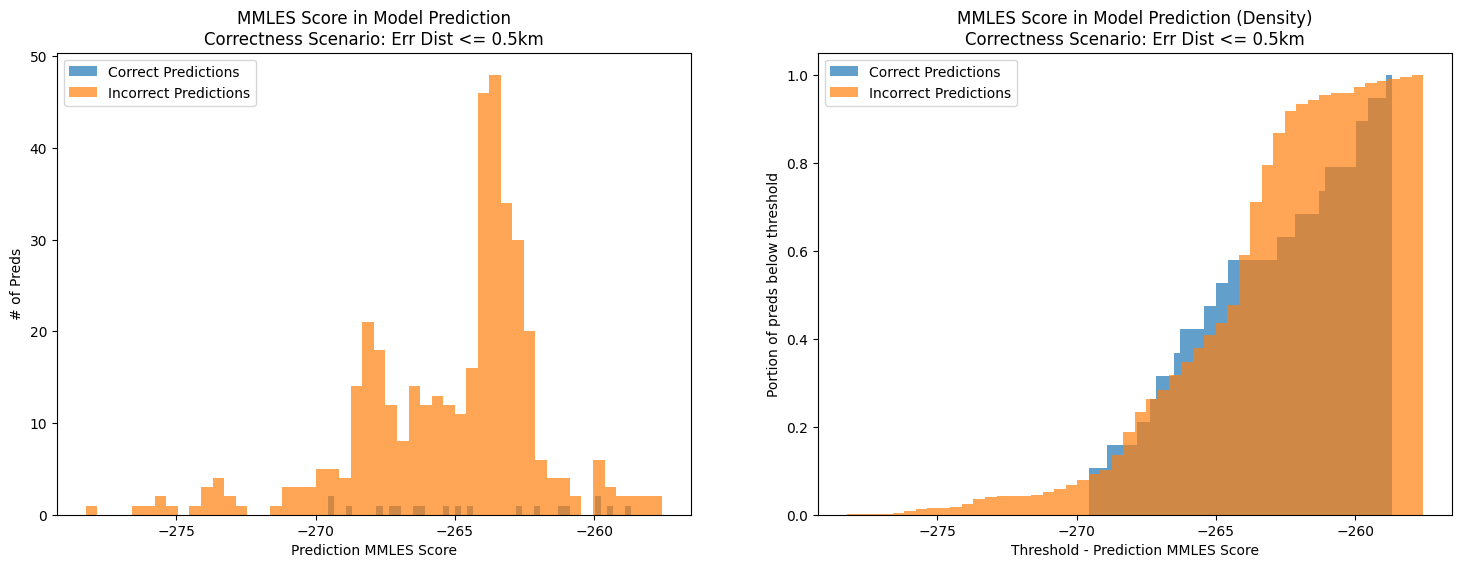

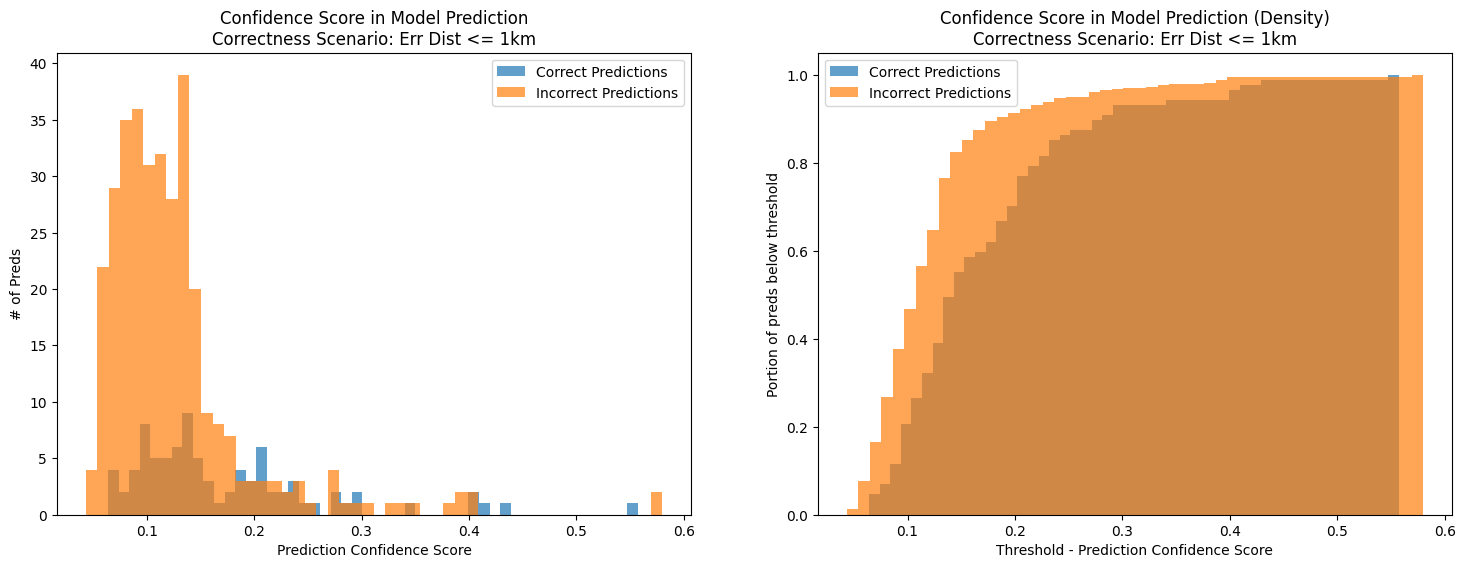

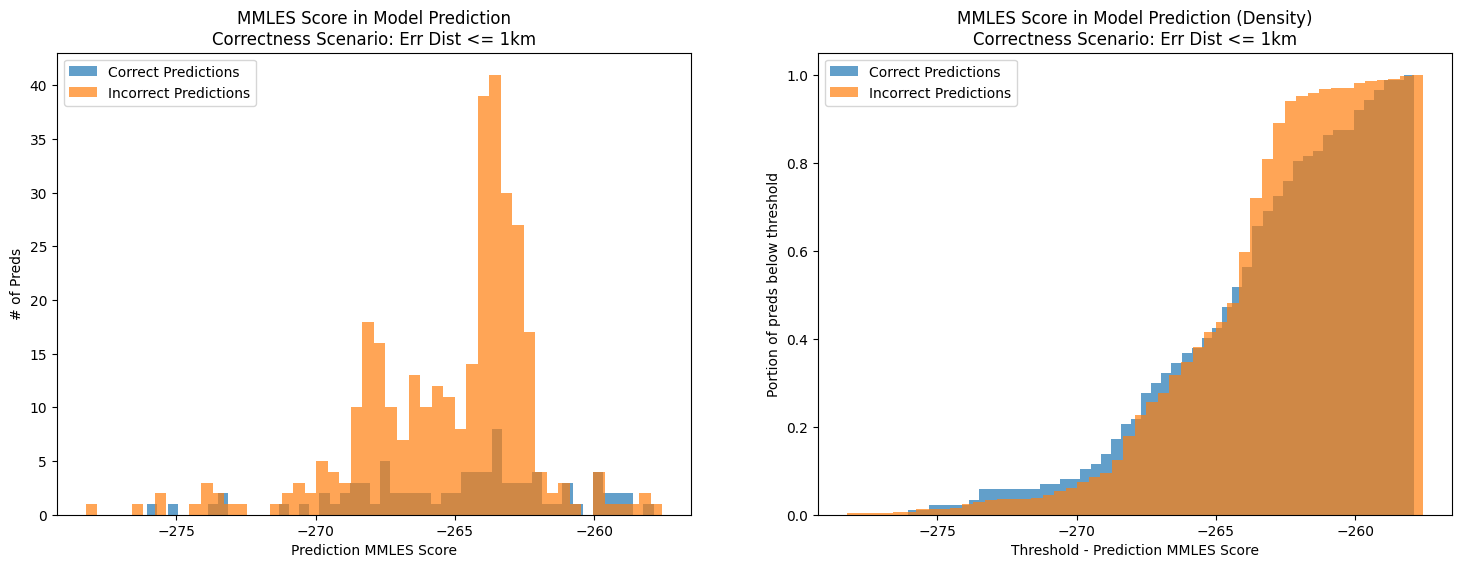

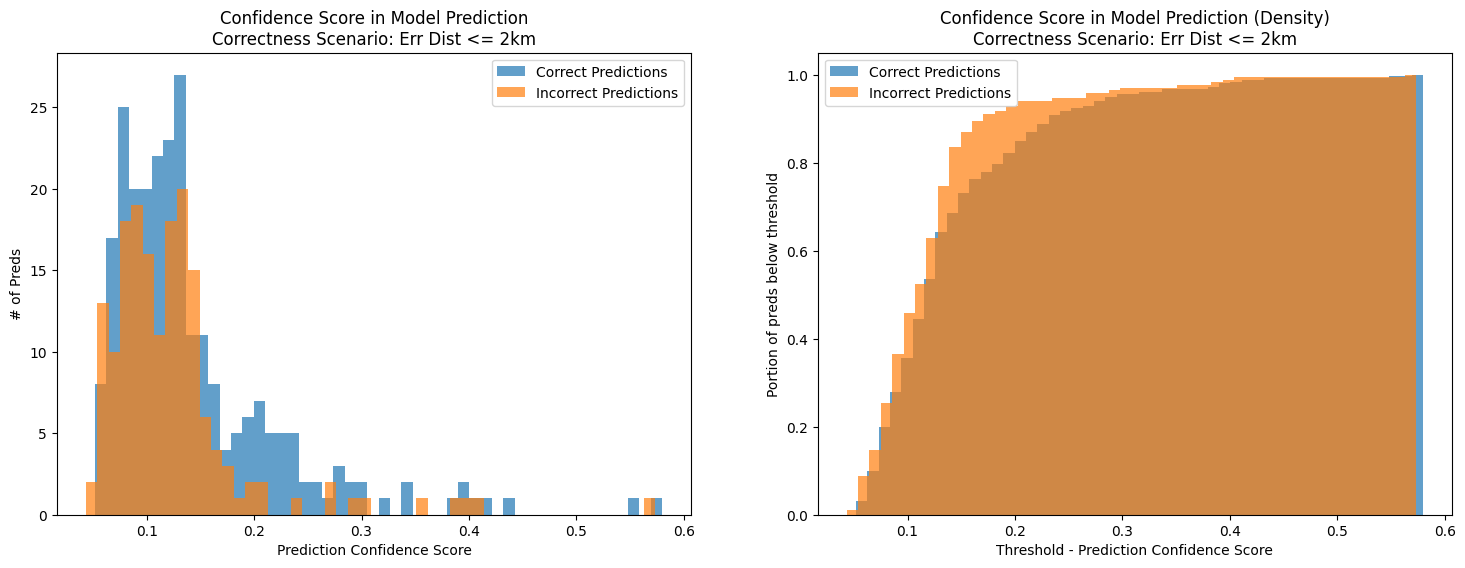

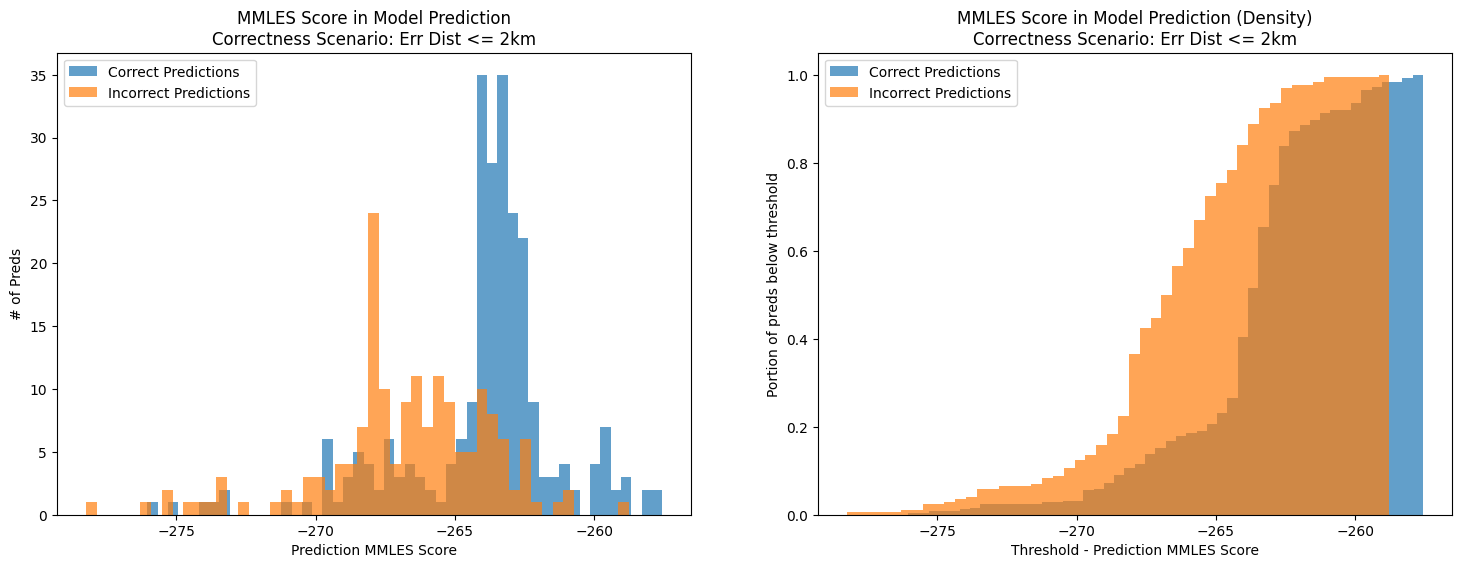

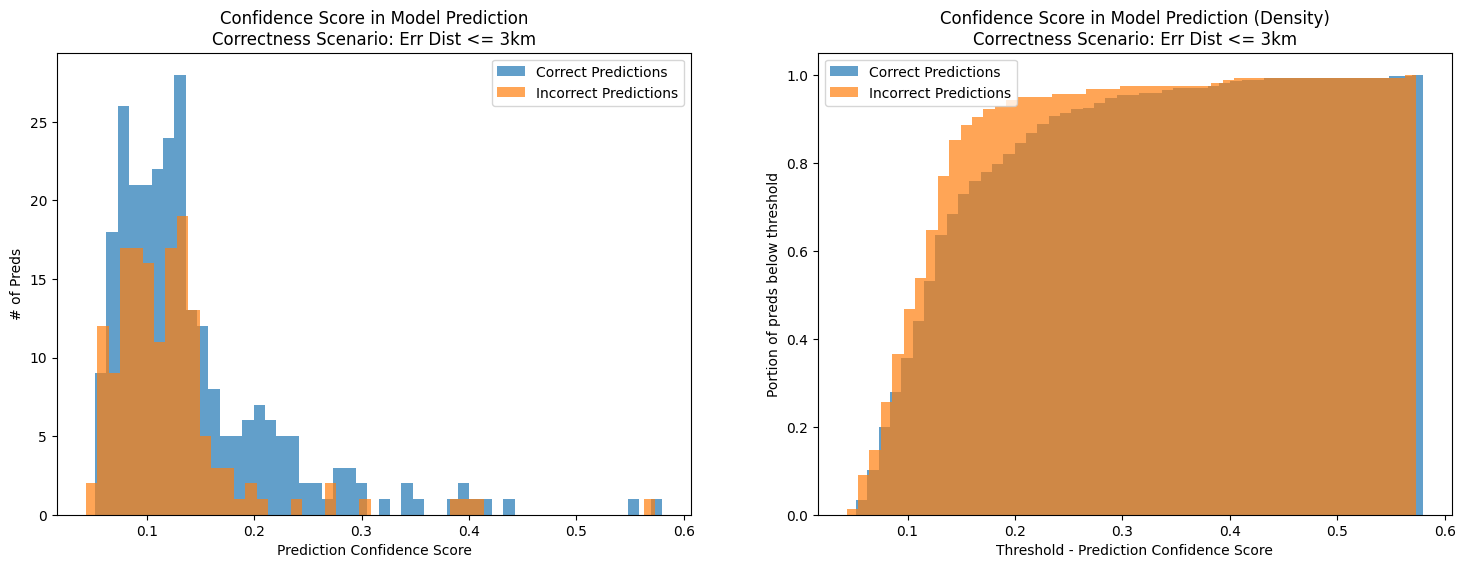

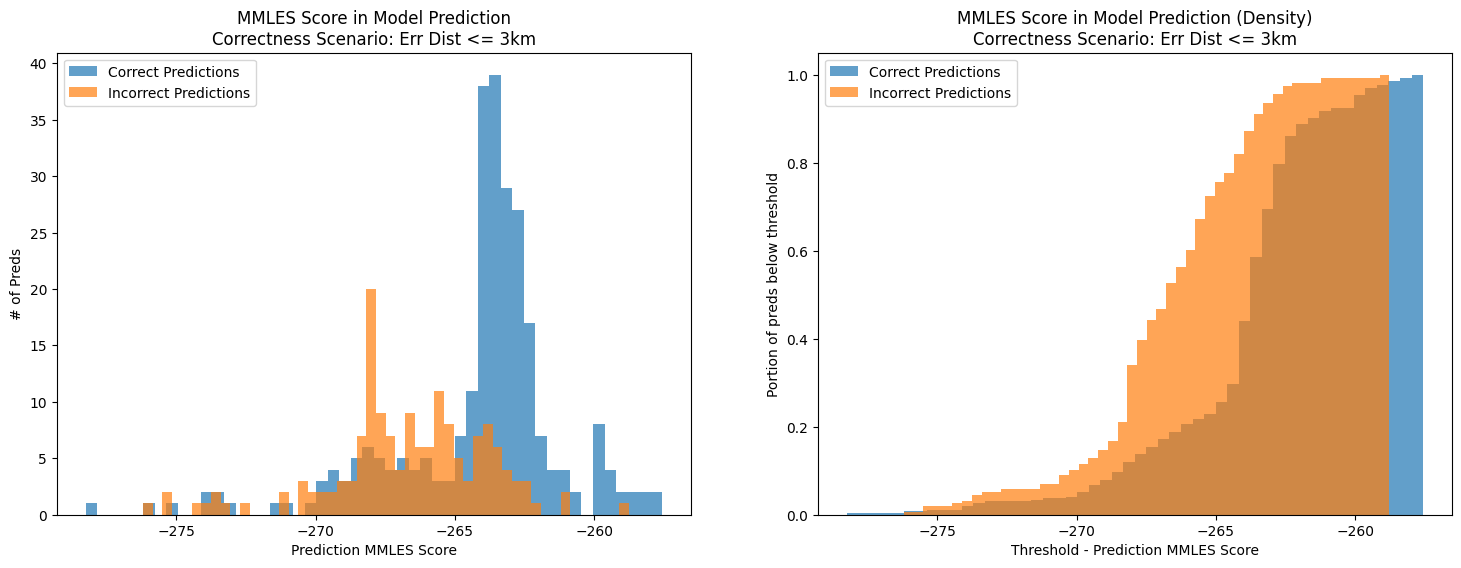

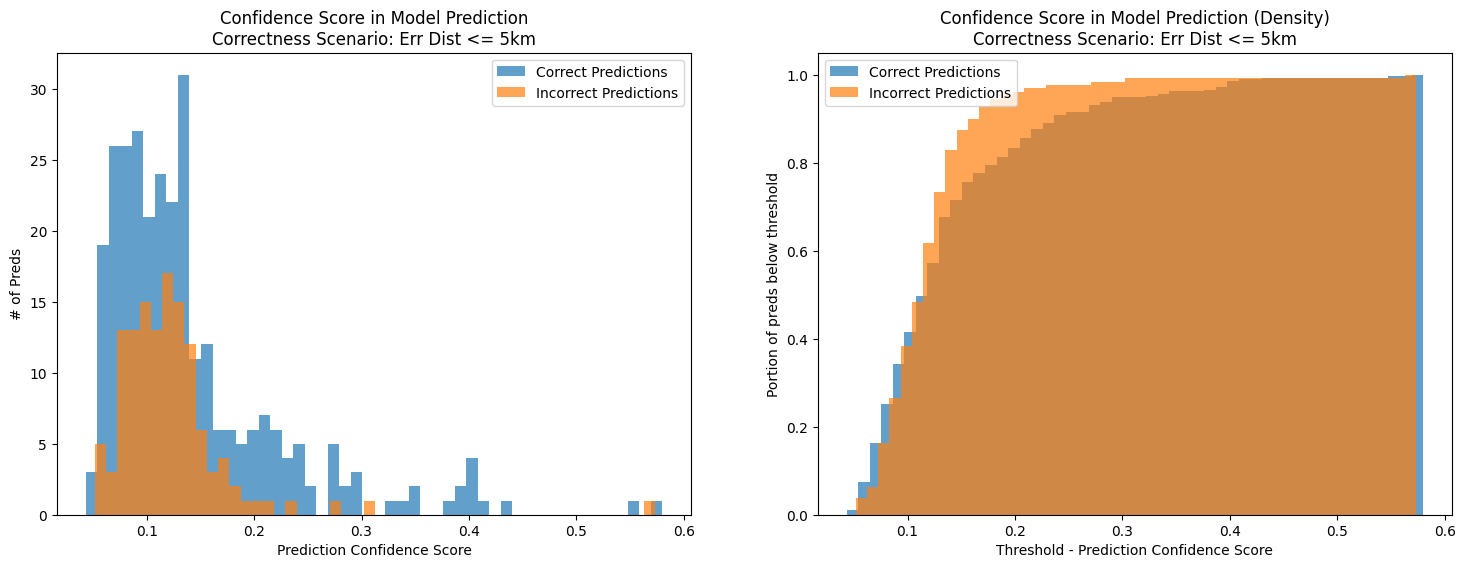

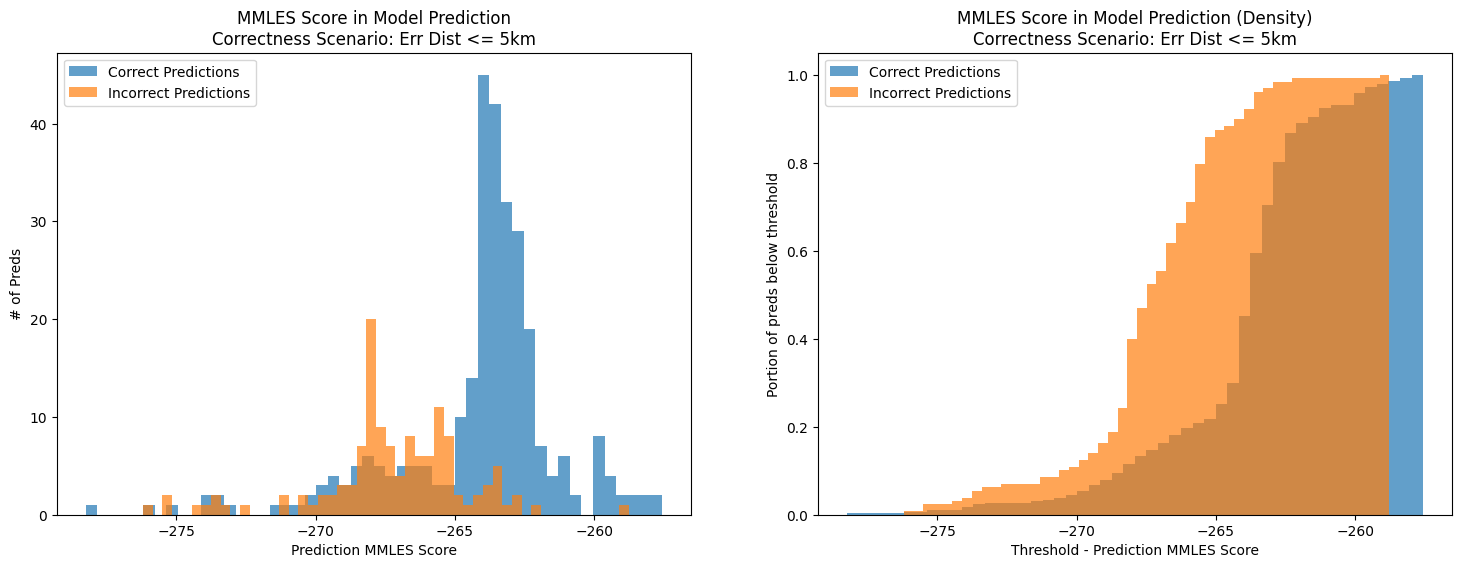

In [15]:
n_bins = 50
scenarios = [("Exact Cluster Match", is_correct)] + [(f"Err Dist <= {thresh_km}km", dist_err_km <= thresh_km) for thresh_km in (0.5, 1,2,3,5)]
for scenario_name, considered_correct in scenarios:
    for metric_name, metric in [("Confidence Score",  confidence), ("MMLES Score", mmles_scores)]:
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(1,2,1)
        ax.hist(metric[considered_correct], bins=n_bins, alpha=0.7, label="Correct Predictions")
        ax.hist(metric[np.invert(considered_correct)], bins=n_bins, alpha=0.7, label="Incorrect Predictions")
        ax.set_title(f"{metric_name} in Model Prediction\nCorrectness Scenario: {scenario_name}")
        ax.set_xlabel(f"Prediction {metric_name}")
        ax.set_ylabel("# of Preds")
        ax.legend()

        ax = fig.add_subplot(1,2,2)
        ax.hist(metric[considered_correct], bins=n_bins, density=True, cumulative=True, alpha=0.7, label="Correct Predictions")
        ax.hist(metric[np.invert(considered_correct)], bins=n_bins, density=True, cumulative=True, alpha=0.7, label="Incorrect Predictions")
        ax.set_title(f"{metric_name} in Model Prediction (Density)\nCorrectness Scenario: {scenario_name}")
        ax.set_xlabel(f"Threshold - Prediction {metric_name}")
        ax.set_ylabel("Portion of preds below threshold")
        ax.legend()
        plt.show()


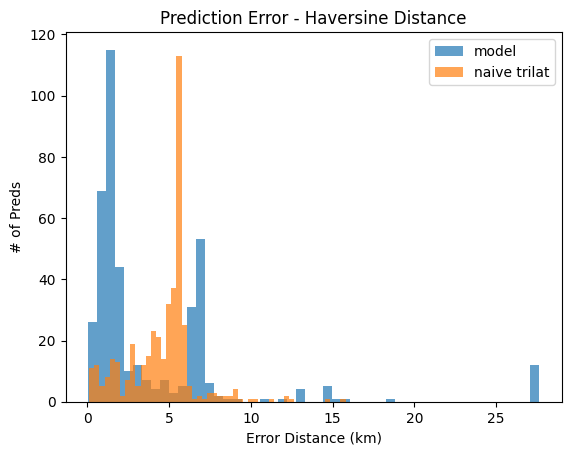

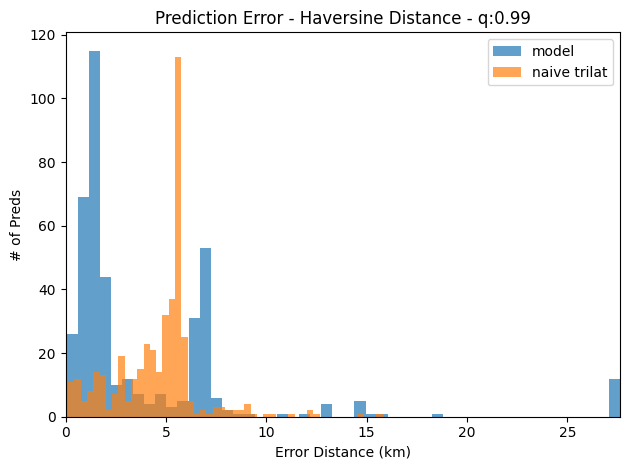

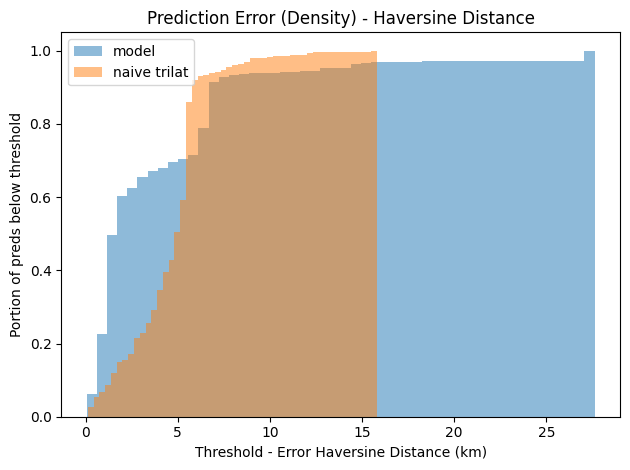

In [16]:
# Look at distribution:
n_bins = 50
plt.hist(dist_err_km, bins=n_bins, alpha=0.7, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.7, label="naive trilat")
plt.title("Prediction Error - Haversine Distance")
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
# plt.tight_layout()
plt.legend()
plt.show()

# Zoom in
plt.figure()
plt.hist(dist_err_km, bins=n_bins, alpha=0.7, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.7, label="naive trilat")
plt.title("Prediction Error - Haversine Distance - q:0.99")
plt.xlim(0, np.quantile(dist_err_km, 0.99))
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.title("Prediction Error (Density) - Haversine Distance")
plt.hist(dist_err_km, bins=n_bins, alpha=0.5, density=True, cumulative=True, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.5, density=True, cumulative=True, label="naive trilat")
plt.xlabel("Threshold - Error Haversine Distance (km)")
plt.ylabel("Portion of preds below threshold")
plt.legend()
plt.tight_layout()
plt.show()